# Emotion Detection

** Importing required libraries**

In [37]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
import sys
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.16.1


**Exploring Dataset**

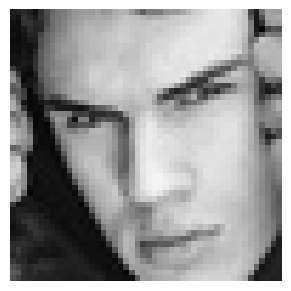

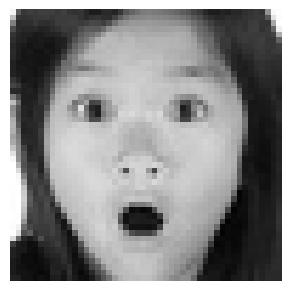

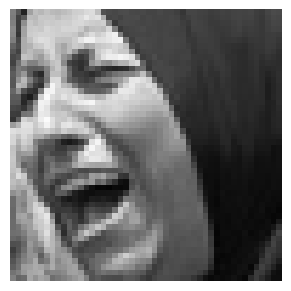

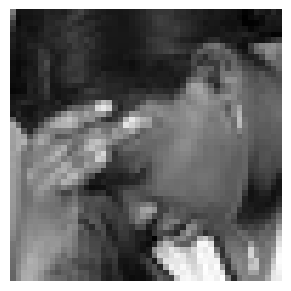

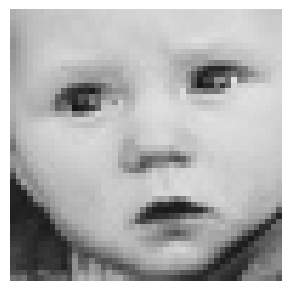

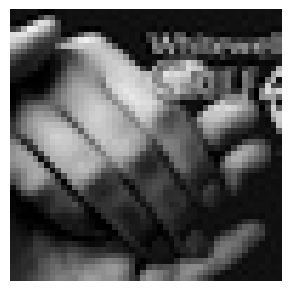

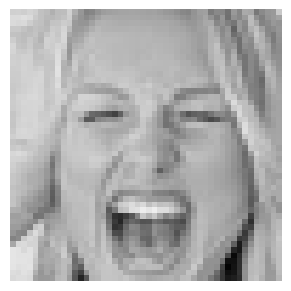

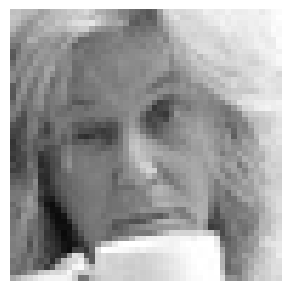

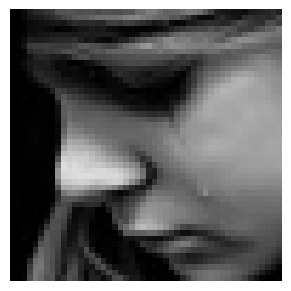

In [38]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize = (12,12))
    plt.subplot(331 + i)
    plt.imshow(cv2.imread(image));  plt.axis('off')

Preparing Data for Training

In [39]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
                                                   target_size = (img_size, img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                   target_size = (img_size, img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Defining Model**

In [40]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    
    return x

In [41]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    return x

In [42]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv1 = Convolution(inputs, 32, (3,3))
    conv2 = Convolution(inputs, 64, (5,5))
    conv3 = Convolution(inputs, 128, (3,3))
    
    flatten = Flatten()(conv3)
    
    dense_1 = Dense_f(flatten, 256)
    
    output = Dense(7, activation = "softmax")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])
    
    model.compile(loss = ['categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [43]:
model = model_fer((48,48,1))
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 48, 48, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,879,239 (72.02 MB)

 Trainable params: 18,878,471 (72.02 MB)

 Non-trainable params: 768 (3.00 KB)

**Initialising the model**

In [44]:
# file_path = r'C:\Users\shrey\OneDrive\Desktop\Emotional Detector\model.weights.h5'#.encode(sys.getfilesystemencoding()).decode()
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint('model.weights.h5', monitor = 'val_accuracy', save_weights_only = True, mode = 'max', verbose = 1)
callbacks = [checkpoint]

# Training the model

**This takes time to complete**

In [45]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)


Epoch 1/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3291 - loss: 1.8189
Epoch 1: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 802s 2s/step - accuracy: 0.3292 - loss: 1.8185 - val_accuracy: 0.2686 - val_loss: 1.9675
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:38 757ms/step - accuracy: 0.3594 - loss: 1.5761

c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3594 - loss: 0.7898 - val_accuracy: 0.1000 - val_loss: 1.1598
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4869 - loss: 1.3557
Epoch 3: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1510s 3s/step - accuracy: 0.4869 - loss: 1.3556 - val_accuracy: 0.4256 - val_loss: 1.5154
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:14 703ms/step - accuracy: 0.5312 - loss: 1.3527
Epoch 4: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5312 - loss: 0.6779 - val_accuracy: 0.3000 - val_loss: 0.7559
Epoch 5/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5610 - loss: 1.1867
Epoch 5: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 554s 1s/step - accuracy: 0.5610 - loss: 1.1867 - val_accuracy: 0.3376 - val_loss: 1.7345
Epoch 6/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 4:42 632ms/step - accuracy: 0.5156 - loss: 1.2445
Epoch 6: s

In [46]:
model.save("model.weights.h5")

**Model Evaluation**

In [47]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - accuracy: 0.4591 - loss: 1.6450


[1.658903956413269, 0.4527723491191864]

**Plotting Loss**

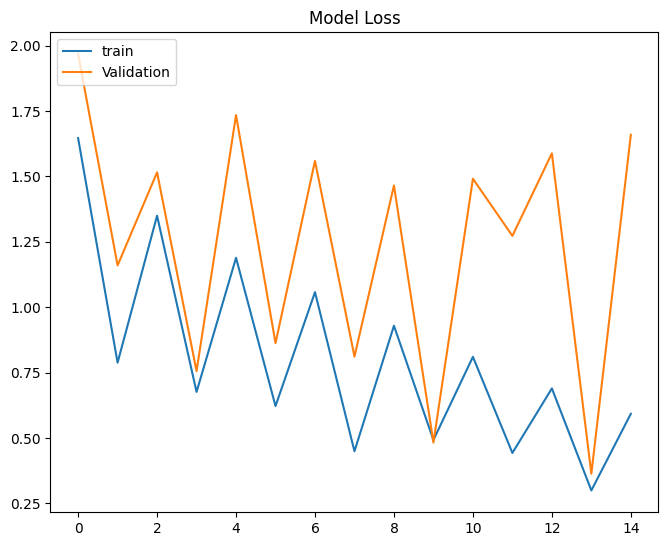

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.legend(['train','Validation'], loc = 'upper left')
plt.subplots_adjust(top = 1.0, bottom = 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace = 0.35)

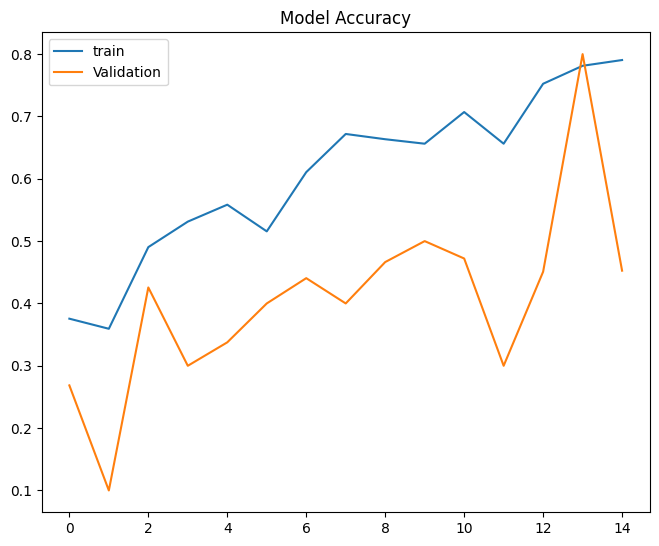

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.legend(['train','Validation'], loc = 'upper left')
plt.subplots_adjust(top = 1.0, bottom = 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace = 0.35)

**Saving the model**

In [50]:
model_json = model.to_json()
with open("model_a.json", "w") as json_file:
    json_file.write(model_json)